## EXPANSÃO TEL+CEM
#### Desenvolvedores: Abner
##### Data da criação: 15 Mar 2024

### Lista de atualizações/modificações:
*
    

In [53]:
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from datetime import datetime
import sys
import numpy as np
import geopy
from geopy import distance
import geopandas as gpd
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import os

In [55]:
# Caminhos dos diretórios raiz

general_path = 'C:/Users/abner/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts'
general_path_tel='C:/Users/abner/OneDrive/Documentos/mestrado/Telemetria-ANA/Scripts e dados'
pd.set_option('display.max_rows', 3300)

current_year = datetime.now().year
mits_integer = [30, 60, 120, 180, 360, 720, 1439]
years = list(range(2014,current_year))

states = ['AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RR','RS','SC','SE','SP','TO']
df_Estacoes_alta=pd.read_excel(general_path+'/Estacoes_Alta_Qualidade_da_Analise_Visual.xlsx')
brasil_uf = gpd.read_file(r'C:\Users\abner\OneDrive\Documentos\mestrado\Telemetria-ANA\Shapefile\Brasil_UF\BR_UF_2022.shp')
plt.rcParams.update({'font.family': 'Times New Roman'})

In [57]:
df_status_cem = pd.read_csv(general_path + '/STATUS_ZERO.csv')
df_status_cem.rename(columns={'Unnamed: 0': 'gauge_code'}, inplace=True)
df_status_tel = pd.read_csv(general_path_tel + '/STATUS_ZERO_TEL.csv')
df_status_tel.rename(columns={'Unnamed: 0': 'gauge_code'}, inplace=True)
#abrir status zero_cem
df_status_cem=pd.read_excel(general_path + '/STATUS_ZERO.xlsx')
df_status_cem.rename(columns={'Unnamed: 0': 'gauge_code'}, inplace=True)
#abrir status zero_tel
df_status_tel=pd.read_csv(general_path_tel + '/STATUS_ZERO_TEL.csv')
df_status_tel.rename(columns={'Unnamed: 0': 'gauge_code'}, inplace=True)
#CONCAT
df_status=pd.concat([df_status_cem, df_status_tel], ignore_index=True).sort_values(by='sum',ascending=False).reset_index(drop=True)
df_status['gauge_code']=df_status['gauge_code'].astype(str)
df_status=df_status.set_index('gauge_code', drop=True)


In [16]:
year=2014

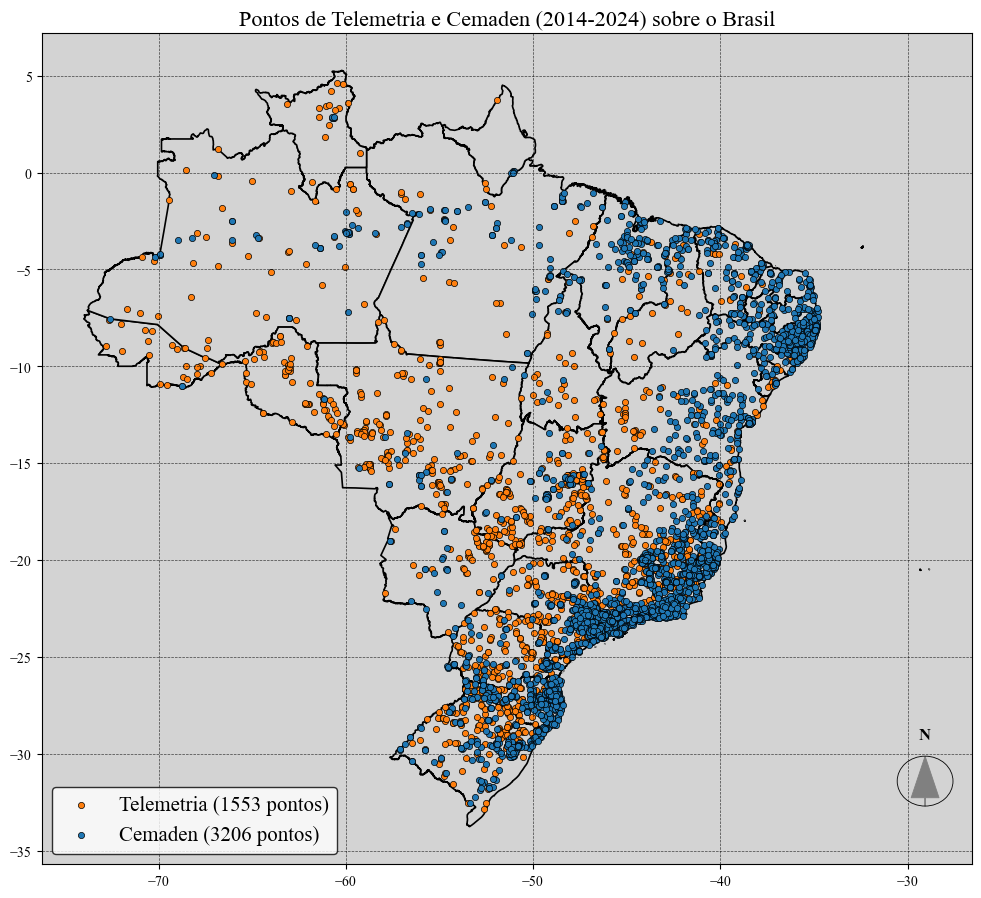

In [27]:



brasil_shapefile = brasil_uf.to_crs('EPSG:4674')
geodf_tel = gpd.GeoDataFrame(df_status_tel, crs='EPSG:4674', geometry=gpd.points_from_xy(df_status_tel.long, df_status_tel.lat))
geodf_cem = gpd.GeoDataFrame(df_status_cem, crs='EPSG:4674', geometry=gpd.points_from_xy(df_status_cem.long, df_status_cem.lat))
num_tel = len(geodf_tel)
num_cem = len(geodf_cem)

fig, ax = plt.subplots(figsize=(12, 12))
brasil_shapefile.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1.2)
geodf_tel.plot(ax=ax, color='#ff7f0e', markersize=20, label=f'Telemetria ({num_tel} pontos)', edgecolor='black', linewidth=0.5)
geodf_cem.plot(ax=ax, color='#1f77b4', markersize=20, label=f'Cemaden ({num_cem} pontos)', edgecolor='black', linewidth=0.5)
ax.set_title("Pontos de Telemetria e Cemaden (2014-2024) sobre o Brasil", fontsize=16)
ax.grid(color='k', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('lightgray')
ax.annotate('N', xy=(0.95, 0.15), xycoords='axes fraction', ha='center', fontsize=12, weight='bold', color='black')
ax.arrow(0.95, 0.07, 0, 0.01, transform=ax.transAxes, color='grey', head_width=0.03, head_length=0.05, linewidth=0.6)
circle = mpatches.Circle((0.95, 0.1), 0.03, transform=ax.transAxes,edgecolor='k', fill=False, linewidth=0.6)
ax.add_patch(circle)
ax.legend(fontsize=15, loc='lower left', frameon=True, edgecolor='black')
output_path = os.path.join(general_path, '2 - Result_images', "Overview_dataset.png")
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()



# CÓDIGO DE EXPANSÃO TEL+CEM

In [34]:
###################### 0- PREENCHER DOAR
states = ['AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RR','RS','SC','SE','SP','TO']
years=[str(year) for year in years]


general_path = 'C:/Users/Windows/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts'
general_path_tel='C:/Users/Windows/OneDrive/Documentos/mestrado/Telemetria-ANA/Scripts e dados'


## FUNCTIONS:


In [35]:
def find_missing_years(df_to_fill, ref_gauge, years):
    
    df_ref = df_to_fill[df_to_fill['gauge_code'] == ref_gauge]
    ref_list = df_ref.iloc[0].squeeze().tolist()[5:5+len(years)]
    
    miss_year_list = []
    for x, y in zip(ref_list, years):
        if x == 0:
            miss_year_list.append(y)
    
    return miss_year_list

In [36]:
def find_common_years(df_to_fill, df_databank, row, idx, years):
    
    common_years = []
    for year in years:
        if df_to_fill.loc[row, str(year)] == 1 and df_databank.loc[idx, str(year)] == 1:
            common_years.append(str(year))
    return common_years

In [37]:
def calc_df_databank(df_to_fill, df_status, row, radius, miss_year,limit_year):
    lat_ref, long_ref = df_to_fill.at[row, 'lat'], df_to_fill.at[row, 'long']
    df_closer = df_status[df_status['sum'] < limit_year]
    df_closer['dist'] = df_closer.apply(lambda x: geopy.distance.distance((x.lat, x.long), (lat_ref, long_ref)).km, axis=1).round(3)
    df_closer = df_closer.sort_values(by=['dist'], ascending=[True])
    df_databank = df_closer[df_closer['dist'] < radius]
    df_databank = df_databank[df_databank[str(miss_year)] == 1]
    df_databank.reset_index(inplace=True)
    df_databank.rename(columns={'index': 'gauge_code'}, inplace=True)

    return df_databank

In [38]:
def calc_mean_absolute_error(df_rainfall_events, comp_year, ref_gauge, subs_gauge, proprietie):
    df_comp = df_rainfall_events[df_rainfall_events['year'] == comp_year]
    df_ref_gauge = df_comp[df_comp['gauge_code'] == ref_gauge]
    df_comp_gauge = df_comp[df_comp['gauge_code'] == subs_gauge]
    mae = (df_ref_gauge.reset_index()[proprietie] - df_comp_gauge.reset_index()[proprietie]).abs().mean()
    return mae

In [39]:
def list_criator(miss_year):
    global code_list,dist_list,compyear_list,num_comoon_years_list,mean_error_list,best_subs_gauge,lowest_error,subs_dist
    code_list=[] # lista de códigos
    dist_list=[] # lista de distancias das estações comparadas
    compyear_list=[] # lista dos anos comparados
    num_comoon_years_list=[] # lista das quantidads de anos em comum
    mean_error_list=[] # lista dos erros médios absolutos
    best_subs_gauge='neighbors have no compyear'
    lowest_error='-'
    subs_dist='-'
    return code_list,dist_list,compyear_list,num_comoon_years_list,mean_error_list,best_subs_gauge,lowest_error,subs_dist

In [40]:
def fill_df_subs_p(df_subs_p, line, df_to_fill, row, miss_year_list, ref_gauge, miss_year, code_list,
                   dist_list, compyear_list, mean_error_list, num_comoon_years_list, best_subs_gauge,
                   lowest_error,subs_dist):
    df_subs_p.at[line, 'long'] = df_to_fill.loc[row]['long']
    df_subs_p.at[line, 'lat'] = df_to_fill.loc[row]['lat']
    df_subs_p.at[line, 'numb_miss_years'] = len(miss_year_list)
    df_subs_p.at[line, 'code_ref'] = ref_gauge
    df_subs_p.at[line, 'ref_year'] = miss_year
    df_subs_p.at[line, 'neighbors'] = code_list
    df_subs_p.at[line, 'dist_list'] = dist_list
    df_subs_p.at[line, 'compared_year'] = compyear_list
    df_subs_p.at[line, 'mean_error'] = mean_error_list
    df_subs_p.at[line, 'number_common_years'] = num_comoon_years_list
    df_subs_p.at[line, 'best_subs_gauge'] = best_subs_gauge
    df_subs_p.at[line, 'lowest_error'] = lowest_error
    df_subs_p.at[line, 'subs_dist'] = subs_dist


### MAIN SCRIPT DF-SUBS:
#### CADA LINHA RECEBE INFORMAÇÃO DAS 3 VIZINHAS MAIS PRÓXIMAS
    Os valores de comparação representam o erro absoluto médio
    Deve ser definida de antemão qual propriedade de comparação
##### SEMPRE EM RELAÇÃO AO ANO EM COMUM MAIS RECENTE

In [25]:
## CONCAtenaR RAINFALL EVENTS TEL ONLY HQ
df_rainfall_events_tel=pd.DataFrame()
for year in years:
    df_tel_hq_list=pd.read_excel(general_path+'/Estacoes_telemetria_HQ.xlsx')[int(year)].dropna().astype(int).tolist()
    df_rainfall_events_tel_year= pd.read_csv(general_path_tel + f'/4 - Mean rainfall events/Main_results_rainfall_events_1mm_{year}.csv',delimiter=';')
    df_rainfall_events_tel_year=df_rainfall_events_tel_year[df_rainfall_events_tel_year['gauge_code'].isin(df_tel_hq_list)].reset_index(drop=True)
    df_rainfall_events_tel=pd.concat([df_rainfall_events_tel, df_rainfall_events_tel_year], ignore_index=True)
    print(year,len(df_tel_hq_list),len(df_rainfall_events_tel_year)/7,len(df_rainfall_events_tel)/7)
    df_rainfall_events_tel.iloc[:, 4:] = df_rainfall_events_tel.iloc[:, 4:].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')
    df_rainfall_events_tel['gauge_code'] = df_rainfall_events_tel['gauge_code'].astype(str)
df_rainfall_events_tel.to_csv(general_path_tel + f'/4 - Mean rainfall events/Main_results_rainfall_events_1mm_allyears.csv', index=False)
print('concluído')

2014 72 72.0 72.0
2015 80 80.0 152.0
2016 293 293.0 445.0
2017 324 324.0 769.0
2018 354 354.0 1123.0
2019 396 396.0 1519.0
2020 403 403.0 1922.0
2021 442 442.0 2364.0
2022 493 493.0 2857.0
2023 430 430.0 3287.0
2024 499 213.85714285714286 3500.8571428571427
concluído


In [79]:
columns_to_convert = [
    'longitute', 'latitude', 'mit_minutes', 'yearly_rainfall', 
    'mean_rainfall_depth', 'mean_rainfall_duration', 'mean_rainfall_intensity', 
    'mean_dry_time', 'sd_rainfall_depth', 'sd_rainfall_duration', 
    'sd_rainfall_intensity', 'sd_rainfall_dry_time', 'max_rainfall_depth', 
    'max_rainfall_duration', 'max_rainfall_intensity', 'max_dry_time'
]

# Converter as colunas para float
df_all_years=pd.read_csv(general_path + f'/4 - Mean rainfall events/Main_results_rainfall_events_1mm_allyears.csv',delimiter=';')
df_all_years[columns_to_convert] = df_all_years[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [98]:
# SET PROPRIETIEs
proprietie='mean_rainfall_intensity'
#propieties=['yearly_rainfall', 'rainfall_events','mean_rainfall_depth','mean_rainfall_duration', 'mean_rainfall_intensity', 'mean_dry_time','sd_rainfall_depth', 'sd_rainfall_duration', 'sd_rainfall_intensity','sd_rainfall_dry_time', 'max_rainfall_depth','max_rainfall_duration','max_rainfall_intensity','max_dry_time']

df_subs=pd.DataFrame(columns=['code_ref','long','lat','ref_year','numb_miss_years','neighbors','dist_list','compared_year','mean_error','number_common_years','best_subs_gauge','lowest_error'])
df_rainfall_events_cem=pd.read_csv(general_path + f'/4 - Mean rainfall events/Main_results_rainfall_events_1mm_allyears.csv',delimiter=';')
#IMPORT RAINFALL_EVENTS_DATA
df_rainfall_events = pd.concat([df_rainfall_events_cem, df_rainfall_events_tel], ignore_index=True)
df_rainfall_events['gauge_code']=df_rainfall_events['gauge_code'].astype(str)
#SET RADIUS TO FIND NEIGHBORS
radius=40

In [101]:
#SET NUMB OF YEARS TO FILL (CURRENT SET :  5)

years_to_fill=5

limit_year=len(years)-years_to_fill
df_to_fill=df_status[df_status['sum']>=limit_year]#o algoritmo tenta preencher todas as estações com no minimo 6 anos
df_to_fill=df_to_fill.sort_values(by=['sum'],ascending = False)
df_to_fill.reset_index(inplace=True)
df_to_fill.head()

,gauge_code,state,city,long,lat,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,sum
0,521190901A,GO,JATAÍ,-51.72500,-17.88700,0,1,1,1,1,1,1,1,1,1,1,10
1,353440103A,SP,OSASCO,-46.77600,-23.50700,0,1,1,1,1,1,1,1,1,1,1,10
2,412570402A,PR,SÃO MIGUEL DO IGUAÇU,-54.22200,-25.34400,0,1,1,1,1,1,1,1,1,1,1,10
3,261160621A,PE,RECIFE,-34.92900,-8.10200,0,1,1,1,1,1,1,1,1,1,1,10
4,351060901A,SP,CARAPICUÍBA,-46.84739,-23.56132,0,1,1,1,1,1,1,1,1,1,1,10


In [102]:
#MAIN SCRIPT

warnings.filterwarnings('ignore') #ignora qualquer aviso!
begin=datetime.now()

for row in df_to_fill.index:
    
    ref_gauge=df_to_fill.loc[row]['gauge_code']  # ref_gauge    
    miss_year_list=find_missing_years(df_to_fill, ref_gauge, years) # missing years list
    
    for miss_year in miss_year_list:
        #df_subs_p limpo para ser preenchido
        df_subs_p=pd.DataFrame(columns=['code_ref','long','lat','ref_year','numb_miss_years','neighbors','dist_list','compared_year','mean_error','number_common_years','best_subs_gauge','lowest_error','subs_dist'])
        line=miss_year_list.index(miss_year) # lines to fill df_subs_p
        df_databank=calc_df_databank(df_to_fill, df_status, row, radius, miss_year,limit_year)#df for possible substitutes
        
        list_criator(miss_year)
        cont = 0
        if df_databank.empty == False: # Only if there are avalieable gauges in that radius
            for idx in df_databank.index:  
                common_years=find_common_years(df_to_fill, df_databank, row, idx, years)# common years list
                if len(common_years) != 0:
                    subs_gauge = df_databank.loc[idx]['gauge_code']#estação comparada
                    code_list.append(subs_gauge)
                    dist_list.append(df_databank.loc[idx]['dist'])
                    comp_year= int(common_years[-1])#ano comparado
                    compyear_list.append(comp_year) #o ano comparado será sempre o mais recente (ultimo elemento da lista de anos em comum)
                    num_comoon_years_list.append(len(common_years))       
                    #MEAN ABSOLUTE ERROR
                    mae = calc_mean_absolute_error(df_rainfall_events, comp_year, ref_gauge, subs_gauge, proprietie)
                    mean_error_list.append(mae)
                    #best subs gauge
                    best_subs_gauge=code_list[mean_error_list.index(min(mean_error_list))]
                    lowest_error=min(mean_error_list)
                    subs_dist=dist_list[mean_error_list.index(min(mean_error_list))]
                    cont=cont+1    
                if cont==3: 
                    break
            
            
            #writing function           
            fill_df_subs_p(df_subs_p, line, df_to_fill, row, miss_year_list, ref_gauge, miss_year,code_list,
                           dist_list, compyear_list, mean_error_list,num_comoon_years_list,best_subs_gauge,lowest_error,subs_dist)
            
            #atualizar status para impedir que a mesma estação seja usada mais de uma vez
            if cont != 0 :
                df_status.at[ref_gauge,str(miss_year)]=1
                df_status.at[best_subs_gauge,str(miss_year)]=0
        
        else:
            fill_df_subs_p(df_subs_p, line, df_to_fill, row, miss_year_list, ref_gauge, miss_year,'no neighbors',
                           'no neighbors', 'no neighbors', 'no neighbors', 'no neighbors','no neighbors','no neighbors','no neighbors')
        df_subs=pd.concat([df_subs,df_subs_p])
        
    ######################################################### time stats
    if row==0:print(datetime.now())
    if row%50==0: print(row,'/',len(df_to_fill.index),)#50 estações concluida
    if row==len(df_to_fill.index)-1:print(datetime.now()-begin)
    ######################################################### aprx 25 min

2025-01-25 10:18:15.819547
0 / 787
50 / 787
100 / 787
150 / 787
200 / 787
250 / 787
300 / 787
350 / 787
400 / 787
450 / 787
500 / 787
550 / 787
600 / 787
650 / 787
700 / 787
750 / 787
0:45:42.395975


In [47]:
df_status['sum'].value_counts()

sum
1     1322
2      882
3      720
4      580
5      468
6      347
7      233
8      130
9       55
10      22
Name: count, dtype: int64

In [106]:
#df ststus
df_status['sum'] = df_status[list(map(str, years))].sum(axis=1)#att sum
df_status.sort_values(by=['sum'],ascending = False,inplace=True)
df_status.to_csv(general_path +'/df_status_final_+5'+proprietie+'_radius_'+str(radius)+'km'+'.csv')
#df subs
df_subs.to_csv(general_path +'/df_subs_+5'+proprietie+'_radius_'+str(radius)+'km'+'.csv')

# PREENCHE DF STATUS


In [45]:
#possíveis substituições que não foram feitas
len(df_subs[df_subs['best_subs_gauge'].isin(['neighbors have no compyear'])])

NameError: name 'df_subs' is not defined

In [133]:
df_substituicoes=df_subs
df_substituicoes = df_substituicoes[~df_substituicoes['best_subs_gauge'].isin(['no neighbors', 'neighbors have no compyear'])].reset_index(drop=True)
df_substituicoes.to_csv(general_path +'/df_substituiçoes_+5'+proprietie+'_radius_'+str(radius)+'km'+'.csv')

In [138]:
len(df_substituicoes)

1595

In [91]:
df_status_fill['sum'].sort_values(ascending=True).value_counts()

sum
1     1715
2      976
3      688
4      385
5      208
10     203
9      173
8      159
11     124
7       72
6       56
Name: count, dtype: int64

In [85]:
df_status_zero['sum'].value_counts()

sum
1     1322
2      882
3      720
4      580
5      468
6      347
7      233
8      130
9       55
10      22
Name: count, dtype: int64

In [81]:
df_status_fill=pd.read_csv(general_path +'/df_status_final_+5'+proprietie+'_radius_'+str(radius)+'km'+'.csv')

In [77]:
#STATUS ZERO PARA COMPARAÇAO
df_status_zero=pd.concat([df_status_cem, df_status_tel], ignore_index=True).sort_values(by='sum',ascending=False).reset_index(drop=True)
df_status_zero['gauge_code']=df_status_zero['gauge_code'].astype(str)
df_status_zero

,gauge_code,state,city,long,lat,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,sum
0,521190901A,GO,JATAÍ,-51.725000,-17.887000,0,1,1,1,1,1,1,1,1,1,1,10
1,412570402A,PR,SÃO MIGUEL DO IGUAÇU,-54.222000,-25.344000,0,1,1,1,1,1,1,1,1,1,1,10
2,313170304A,MG,ITABIRA,-43.195000,-19.595000,0,1,1,1,1,1,1,1,1,1,1,10
3,410330501A,PR,BORRAZÓPOLIS,-51.590000,-23.942000,0,1,1,1,1,1,1,1,1,1,1,10
4,355250203A,SP,SUZANO,-46.322502,-23.496096,0,1,1,1,1,1,1,1,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,330045607A,RJ,BELFORD ROXO,-43.352400,-22.716000,0,0,1,0,0,0,0,0,0,0,0,1
4755,251490901C,PB,S├âO MAMEDE,-37.137130,-6.911830,0,0,0,0,0,1,0,0,0,0,0,1
4756,260410608A,PE,CARUARU,-35.938122,-8.282617,0,0,0,0,0,1,0,0,0,0,0,1
4757,412550605A,PR,S├âO JOS├Ê DOS PINHAIS,-49.148000,-25.484000,0,0,1,0,0,0,0,0,0,0,0,1


##### JUNTAR RESULTS telemetria e cemaden

### PREENCHER RESULTS_SUBS

In [95]:
df_results_subs=pd.read_hdf(general_path +'/Results erosivity/EI30_all_months.h5',key='annual')
df_substituições=pd.read_csv(general_path +'/df_substituiçoes_+5'+proprietie+'_radius_'+str(radius)+'km'+'.csv')
for i in df_substituições.index:
    code=df_substituições.loc[i,'code_ref']
    year=df_substituições.loc[i,'ref_year']
    code_sub=df_substituições.loc[i,'best_subs_gauge']
    df_results_subs.loc[code,str(year)]=df_results_subs.loc[code_sub,str(year)]
    df_results_subs.loc[code_sub,str(year)]='doado'
# att sum
columns = [str(year) for year in range(2014, 2025)]

# Atualizar a coluna 'sum'
df_results_subs['sum'] = df_results_subs[columns].apply(
    lambda row: ((row != 0) & (row != 'doado')).sum(), axis=1
)
df_results_subs=df_results_subs.sort_values(by="sum", ascending=False)

C:\Users\abner\AppData\Local\Temp\ipykernel_15876\1864713621.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'doado' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_subs.loc[code_sub,str(year)]='doado'
C:\Users\abner\AppData\Local\Temp\ipykernel_15876\1864713621.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'doado' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_subs.loc[code_sub,str(year)]='doado'
C:\Users\abner\AppData\Local\Temp\ipykernel_15876\1864713621.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'doado' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_subs.loc[co

In [101]:
df_results_subs.head(600)

,state,city,long,lat,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,sum
gauge_code,,,,,,,,,,,,,,,,
230765004A,CE,MARACANA├Ü,-38.623954,-3.861673,4553.68523,5672.589642,6146.197867,5973.933119,7055.048249,9200.541894,6055.931298,6429.60701,7417.0962,7165.892807,15427.583794,11
351050011A,SP,CARAGUATATUBA,-45.423000,-23.612000,2368.431162,9575.299806,5516.553572,12669.803799,6423.15091,20652.362385,5765.031935,5351.359471,6435.699526,8718.337878,6809.083974,11
420750202A,SC,INDAIAL,-49.233320,-26.881280,8493.297255,11264.975354,8567.2369,7001.080257,7141.31524,3934.7048,5562.917437,7023.960999,9818.98234,12697.06602,4000.177222,11
351870109A,SP,GUARUJÁ,-46.275590,-24.006900,19581.018622,15647.858931,9079.114783,14006.690337,10233.776226,17739.62907,10476.383354,11675.177271,11300.595416,8962.667056,7095.21146,11
420230501A,SC,BIGUAÇU,-48.654340,-27.542100,9683.753335,14594.618339,8797.826609,5489.017952,12222.72544,9254.690763,3853.326461,11390.268852,10761.552752,6992.538844,12006.475141,11
421130604A,SC,NAVEGANTES,-48.630000,-26.835000,7957.880905,10433.930769,12078.927547,6478.934471,8703.794296,10233.105513,5922.021057,6354.763104,8159.620026,12246.964294,9492.672079,11
350250703A,SP,APARECIDA,-45.260300,-22.868100,2113.814812,5237.415564,6292.756563,7249.505197,8204.134544,3461.71178,5632.198819,5818.500195,5057.004904,12115.747423,7899.5198,11
355280901A,SP,TABOÃO DA SERRA,-46.778200,-23.621200,4864.247849,11375.928042,8685.983295,8425.965803,8376.351667,8633.592825,7621.479416,7704.120861,9746.182167,7552.076373,6513.75344,11
330414405A,RJ,QUEIMADOS,-43.580100,-22.691500,1287.294088,7324.574893,9663.695809,4777.692981,5133.026442,9499.391111,5677.605868,11386.164796,9390.699023,7401.627399,13270.619042,11


In [169]:
df_ei_30 = pd.read_hdf(general_path + '/Results_Erosivity_filled.h5', key='EI_30').head(662)
df_e_d = pd.read_hdf(general_path + '/Results_Erosivity_filled.h5', key='E_D').head(662)

# Definir as colunas alvo (2014 a 2024)
columns_to_operate = [str(year) for year in range(2014, 2025)]
df_e_d[columns_to_operate] = df_e_d[columns_to_operate].replace(0, np.nan)
# Garantir que as colunas existam em ambos os DataFrames antes da operação
if set(columns_to_operate).issubset(df_ei_30.columns) and set(columns_to_operate).issubset(df_e_d.columns):
    # Divisão para calcular a nova chave 'rain'
    df_rain=df_ei_30
    df_rain[columns_to_operate] = df_ei_30[columns_to_operate].divide(df_e_d[columns_to_operate])
    
    # Salvar a nova chave no arquivo HDF5
    df_rain.to_hdf(general_path + '/Results_Erosivity_filled.h5', key='rain')
    result = "Chave 'rain' adicionada ao arquivo HDF5 com sucesso!"
else:
    result = "Colunas especificadas não existem em ambos os DataFrames."

result

"Chave 'rain' adicionada ao arquivo HDF5 com sucesso!"

In [109]:
df_results_subs.to_excel(general_path + '/Results erosivity/validation_dataset.xlsx')